In [1]:
from func import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os

In [2]:
# ",".join(os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/NAKO'))

In [3]:
volume_txt_file = 'datasets/nako/volumes.txt'
data_dir = "/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI"
label_dir = 'datasets/lablmaps/NAKO'

n4_corrected_data_dir = "temp/NAKO/n4_corrected"
stictched_data_dir = "temp/NAKO//stitched"
stitched_n4_corrected_data_dir = "temp/NAKO/stitched_n4_corrected"

processed_path = 'temp/NAKO/'
processed_dir = 'temp/NAKO/processed'

one_time_n4_optimization = True

In [4]:
def load_nako_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        
        opp_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_opp/**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_in/**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_F/**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_W/**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths
        

In [ ]:
file_paths = load_nako_file_paths()

In [ ]:
 print(json.dumps(file_paths,sort_keys=True, indent=4))

In [ ]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'applying n4 bias field on opp scans of {vol}...')
    vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
    idx = 0
    file_paths[vol]['N4_1'] = []
    for opp_img, bias_field_img, opp_file in vol_parts:
        file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
        idx+=1
#         n4_dict[vol].append(rescale(opp_image, vol, n4_dict[vol]))



In [ ]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'

In [ ]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    print(f'applying n4 bias field on stitched opp scans of {vol}...')

    opp_file = file_paths[vol]['ONE']['OPP']
    n4_counterpart = n4_dict[vol]['N4_2']
    print(opp_file, n4_counterpart['IN_BIAS'])
    opp_img = read_ras(opp_file)
    bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

    file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

In [ ]:
with open('nako_file_paths.p', 'wb') as handle:
    p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [6]:
with open('nako_file_paths.p', 'rb') as handle:
    file_paths = p.load(handle)

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
100094
['datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Spleen.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transform

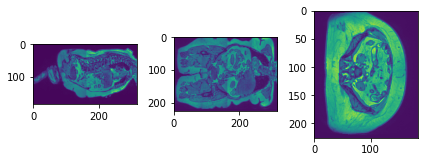

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0550000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


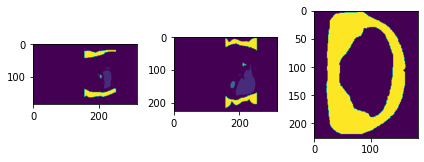

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100025
['datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver-2.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right) .nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D

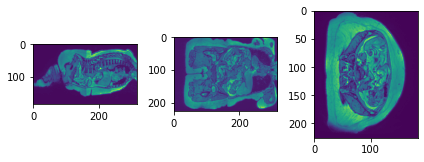

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


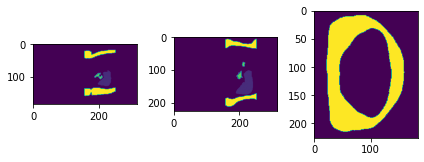

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100129
['datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Spleen.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Liver.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Kidney (right)-2.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Adrenal gland(left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS....

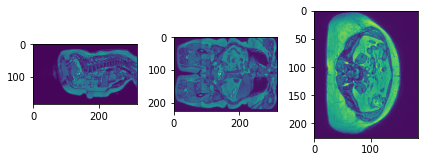

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0850000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


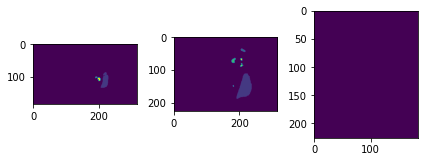

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100013
['datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2-3_subcutan_fat.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100013/100113_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_2_spleen.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GTE_TRA_opp_2_nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GR_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Panc

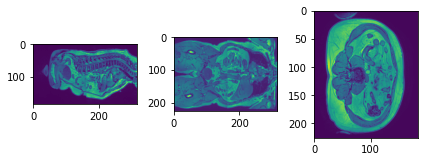

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0850000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


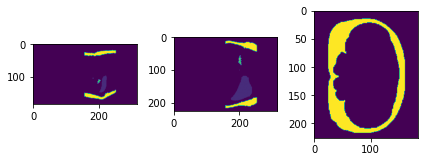

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100161
['datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Spleen.nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Pancreas.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Rea

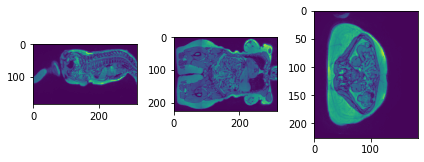

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2609375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


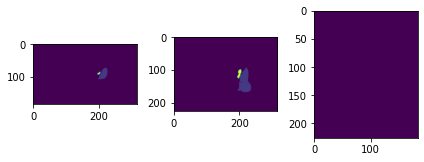

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100183
['datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Liver-2.nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Spleen.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Rea

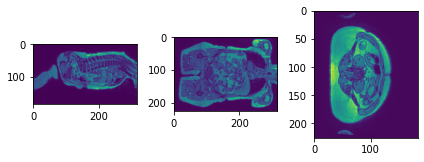

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.9140625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0300000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


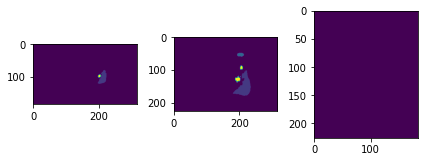

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100006
['datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100006/10006_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100006/100006_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Imag

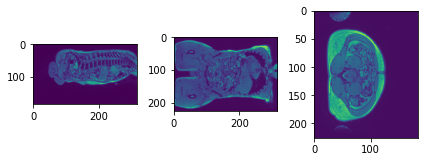

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.0359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1075000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


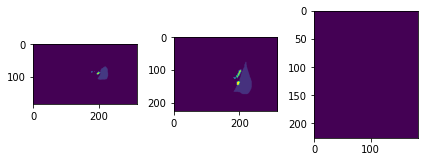

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100035
['datasets/lablmaps/NAKO/100035/35_spl.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_2_nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd']
Reading Fi

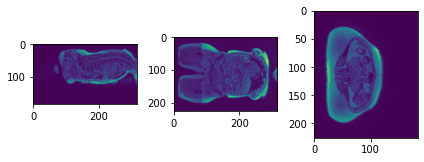

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3609375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0625000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


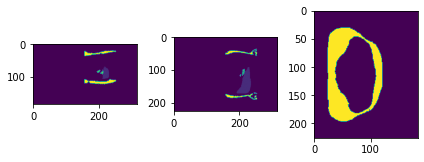

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100085
['datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(left).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver-2-2.nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Rea

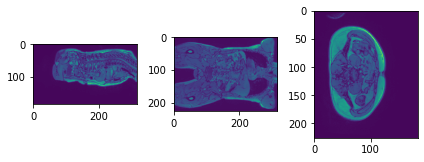

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1125000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


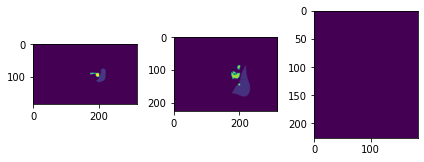

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100181
['datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Spleen-2.nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Liver-4.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Re

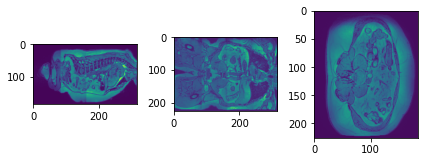

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.48899841e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.09223022e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


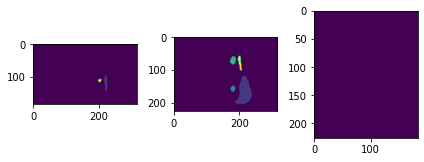

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100112
['datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transformin

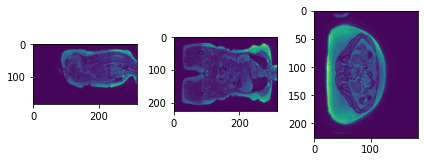

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


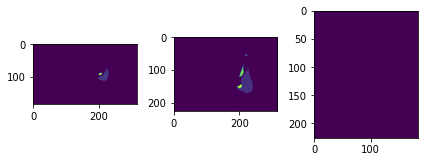

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100142
['datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD 

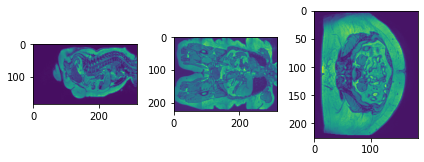

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.6640625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0825000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


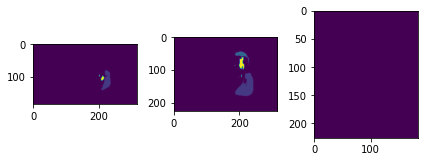

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100017
['datasets/lablmaps/NAKO/100017/100017 _3D_GRE_TRA_opp_3D_GRE_TRA_2_subcutaneous.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_2_nii_Spleen.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas-2.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GTE_TRA_opp_2_nii_Liver-2-3.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Ki

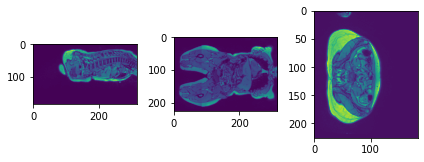

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.1609375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1325000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


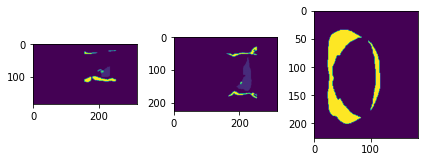

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100009
['datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files...

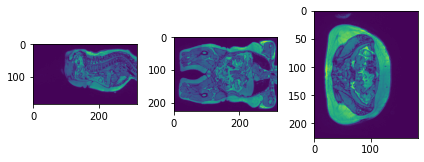

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1050000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


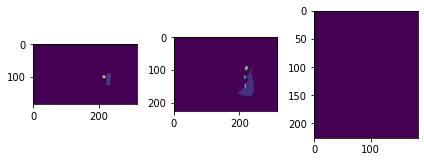

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100116
['datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Spleen.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Liver.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Adrenal gland(right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....


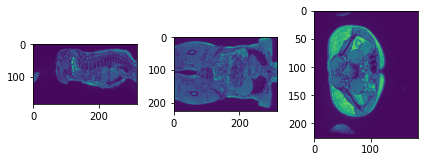

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0750000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


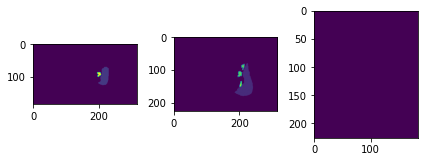

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100020
['datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder (1).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100020/10020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA

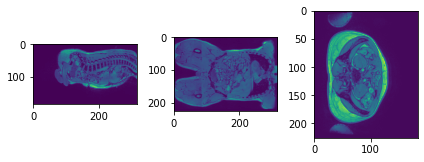

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1025000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


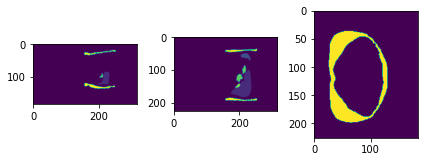

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100008
['datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Spleen-5.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder (1).nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100008/10008_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right) (1).nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_1_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(left)-4.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas-3.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_T

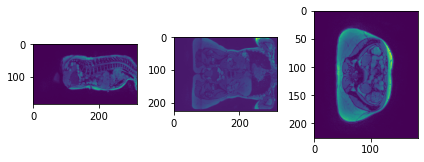

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.31093750e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -2.14435913e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04476697e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


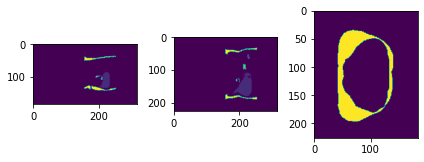

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100083
['datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(left).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(right).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....

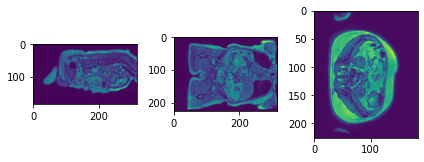

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0600000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


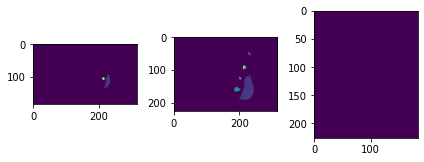

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.
100097
['datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Spleen.nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Liver.nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to R

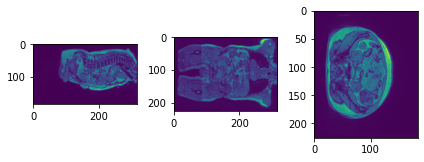

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0975000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


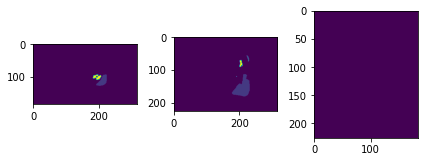

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.


In [13]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    later = None
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        print(img_ras.shape)
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape)
        mode='constant'
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
    #     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine])
        if labelname == 'SPLEEN':
            later = [img_ras, lidx, labelname]
        else:
            img_ras_list.append([img_ras, lidx, labelname])
    if later is not None:
        img_ras_list.append(later)
    s_label = label_parts(img_ras_list)
    volume, s_label = vol_label_fix(volume, s_label)
    #     volume, stitched_label = combine_nako_seg(file_paths[vol]['LABEL_PATHS'],'' ,file_paths[vol]['N4_2']['OPP_CORRECTED'])

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))

    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')
    
    


In [ ]:
# file_dict= 
# {
#     VOL_ID: {
#         VOLUME_PATHS: {
#             OPP: [],
#             IN: [],
#             F: [],
#             W: []
#         },
#         LABEL_PATHS: [],
#         N4_1: [
#             {
#                 SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#                 IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#                 IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#                 OPP_CORRECTED: '',
#                 MIN: u_min,
#                 MAX: u_max
#             },
#             {},
#             {}
#         ],
#         ONE: {
#             OPP: '',
#             IN: '',
#             F: '',
#             W: '',
#         },
#         N4_2: {
#             SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#             IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#             IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#             OPP_CORRECTED: '',
#             MIN: u_min,
#             MAX: u_max
#         },
        
#     }
# }